In [3]:
import psycopg2
from sqlalchemy import create_engine
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import time
import random
import plotly.express as px
from datetime import timedelta



In [4]:
general_path = 'E:/paper2_analysis/connect_flood_roads_to_trafficmodel'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

----------

#### result from flood

In [6]:
## json with all flood depth on sample points

## sample with only classified roads (osm classifacation)
# uuid = 'ba14e504-b4ef-11ec-b830-acde48001122' 


## sample with all roads
subfolder = 'sample_alle_wegen' 
uuid = '28d386f4-b66b-11ec-acdd-acde48001122'

sample_size = 10000



# name_flood_result = 'flooddepth_time_road_segments_df_dh_scen1_voorpiek_sz2000_uuid_66e0b6ee-e4af-11eb-a904-acde48001122'
name_flood_result = f'flooddepth_time_road_segments_df_dh_scen1_voorpiek_sz{sample_size}_uuid_{uuid}'



flooded_roads = pd.read_json(f'{input_path}/{subfolder}/{name_flood_result}.json')
flooded_roads.head(2)


,102970,67676,83735,24693,117260,99347,123267,83784,65852,42237,...,123279,122626,121654,123293,90423,25265,95440,70772,71229,18516
2000-01-01 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 18:05:10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# df_osmid_flood.to_csv(f'{output_path}/df_osmid_flood.csv', header= True, sep =';', decimal=',' )

In [12]:
#shapefile of all point where sample is taken from
# geoms_floodcalc_nodes_name = 'created_wegdelen_OSM_centroids_cell_id_floodselection_without_bridges_and_initwater'

geoms_floodcalc_nodes_name = f'segmentcentroid_df_samplesize_{sample_size}_uuid_{uuid}'

geoms_floodcalc_nodes = gpd.read_file(f'{input_path}/{subfolder}/{geoms_floodcalc_nodes_name}.geojson')

#change osmid to integers (instead oof float)
geoms_floodcalc_nodes = geoms_floodcalc_nodes.astype({"osmid": int})

In [13]:
len(geoms_floodcalc_nodes)

10000

-------------

#### calculate flood arrival time for every node

In [14]:
## create db with arrival times for every calculation point
df_segments_flood = pd.DataFrame(columns=['segmentid', 'arrivaltime', 'minutes', 'firstdepth', 'geometry'])

#get all column names
list_segment_in_comp = flooded_roads.columns.values.tolist()

df_segments_flood["segmentid"] = list_segment_in_comp
df_segments_flood.head(1)

,segmentid,arrivaltime,minutes,firstdepth,geometry
0,102970,NaN,NaN,NaN,NaN


In [15]:
## derive flood arrival and first depth--> append it to dataframe
for index, value  in flooded_roads.items():
    
    for i in range(len(value)):
                   if value[i] > 0.01:
                    arrival_time = str(flooded_roads.index[i])
                    arrival_minutes = int(i * 5) #let op, deze 5 is van 5 minute timestep-> moet anders. niet hard coded

                    first_depth = value[i]
                    osmid = value.name
                    geom = geoms_floodcalc_nodes
                    
                    df_segments_flood.loc[df_segments_flood.segmentid == osmid, 'minutes'] = int(arrival_minutes)
                    df_segments_flood.loc[df_segments_flood.segmentid == osmid, 'arrivaltime'] = arrival_time
                    df_segments_flood.loc[df_segments_flood.segmentid == osmid, 'firstdepth'] = first_depth
            
                    break

df_segments_flood.to_csv(f'{output_path}/df_segments_flood_{uuid}.csv', header= True, sep =';', decimal=',' )               
df_segments_flood.to_json(f'{output_path}/df_segments_flood_{uuid}.json')               
df_segments_flood.head()

,segmentid,arrivaltime,minutes,firstdepth,geometry
0,102970,2000-01-01 18:45:03,45,0.106573,NaN
1,67676,2000-01-02 00:20:04,380,0.012809,NaN
2,83735,2000-01-01 18:50:03,50,0.384264,NaN
3,24693,2000-01-02 04:50:03,650,0.07702,NaN
4,117260,2000-01-01 20:25:03,145,0.171414,NaN


### join geoms of segments with new dataframe

In [16]:
df_segments_flood_geoms_temp  = pd.merge(df_segments_flood,geoms_floodcalc_nodes,left_on='segmentid', right_on='roadsegmen' )
df_segments_flood_geoms_temp["geom"] = df_segments_flood_geoms_temp.geometry_y
df_segments_flood_geoms_temp = df_segments_flood_geoms_temp.drop(columns=['geometry_y', 'geometry_x'])

df_segments_flood_geoms = gpd.GeoDataFrame(df_segments_flood_geoms_temp, geometry= 'geom')
df_segments_flood_geoms.head(3)


,segmentid,arrivaltime,minutes,firstdepth,maaiveld,functie,roadsegmen,cell_id,osmid,highway,geom
0,102970,2000-01-01 18:45:03,45,0.106573,0.957,rijbaan lokale weg,102970,10855.0,6641323,secondary,POINT (111357.646 550899.011)
1,67676,2000-01-02 00:20:04,380,0.012809,1.435,rijbaan lokale weg,67676,65774.0,6641639,unclassified,POINT (113159.539 542211.145)
2,83735,2000-01-01 18:50:03,50,0.384264,1.342,rijbaan regionale weg,83735,29212.0,6640021,primary,POINT (113384.844 552845.117)


In [17]:
df_segments_flood_geoms.to_file(f'{output_path}/df_segments_flood_geoms1_{uuid}.geojson')

C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
## TO DO:
# minutes after start gaat nu bij export naar string. why?


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


<AxesSubplot:>

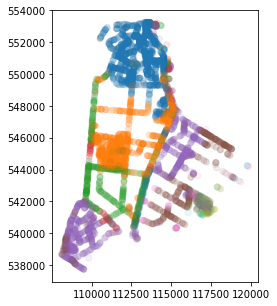

In [18]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
df_segments_flood_geoms.plot(ax=ax,alpha = 0.1, column = 'minutes')

# let op!

#### let op, bij de N90 zitten een paar foutjes, de segments te dicht op de watergang. \
#### en pakken daarom initieel water als minuten. Deze nu handatig in gis verwijderd
